In [2]:
# algorithms: K-means, DBSCAN, BIRCH, Gaussian Mixture Model (GMM),Agglomerative
# datasets: 1) https://archive.ics.uci.edu/dataset/352/online+retail
#           2) https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce


# 1) Process data into RFM
# R (Recency): Number of days since last purchase
# F (Frequency): Number of tracsactions
# M (Monetary): Total Amount of transactions (revenue contributed)

# Run loop over list of algorithms

In [3]:
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, Birch, AgglomerativeClustering
from sklearn.metrics import silhouette_score


import matplotlib.pyplot as plt

Read input dataset Online Retail

In [4]:
data = pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


Clean data

In [5]:
print(len(data[data["Price"] < 0]))
print(len(data[data["Quantity"] < 0]))

5
22950


In [6]:
data = data[data["Price"] >= 0]
data = data[data["Quantity"] >= 0]

In [7]:
data.isna().all()

Invoice        False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
Price          False
Customer ID    False
Country        False
dtype: bool

In [8]:
data["Monetary"] = data["Quantity"]*data["Price"]
Monetary = data.groupby('Customer ID')['Monetary'].sum()
Monetary = Monetary.reset_index()
Monetary

,Customer ID,Monetary
0,12346.0,77556.46
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4428.69
4,12350.0,334.40
...,...,...
5876,18283.0,2736.65
5877,18284.0,461.68
5878,18285.0,427.00
5879,18286.0,1296.43


In [9]:
Frequency = data.groupby('Customer ID')['Invoice'].count()
Frequency = Frequency.reset_index()
Frequency

,Customer ID,Invoice
0,12346.0,34
1,12347.0,253
2,12348.0,51
3,12349.0,175
4,12350.0,17
...,...,...
5876,18283.0,986
5877,18284.0,28
5878,18285.0,12
5879,18286.0,67


In [10]:
data["InvoiceDate"] = pd.to_datetime(data['InvoiceDate'],format='%Y-%m-%d %H:%M:%S')
latest_time = max(data["InvoiceDate"])
data["day_diff"] = latest_time - data["InvoiceDate"]
data["day_diff"] = data["day_diff"].dt.days

Recency = data.groupby("Customer ID")['day_diff'].min()
Recency = Recency.reset_index()
Recency

,Customer ID,day_diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
5876,18283.0,3
5877,18284.0,431
5878,18285.0,660
5879,18286.0,476


In [11]:
RFM = Monetary.merge(Frequency, left_on = "Customer ID", right_on = "Customer ID")
RFM = RFM.merge(Recency, left_on = "Customer ID", right_on = "Customer ID")

RFM.rename({"Invoice": "Frequency", "day_diff":"Recency"}, axis = 1, inplace = True)
RFM

,Customer ID,Monetary,Frequency,Recency
0,12346.0,77556.46,34,325
1,12347.0,5633.32,253,1
2,12348.0,2019.40,51,74
3,12349.0,4428.69,175,18
4,12350.0,334.40,17,309
...,...,...,...,...
5876,18283.0,2736.65,986,3
5877,18284.0,461.68,28,431
5878,18285.0,427.00,12,660
5879,18286.0,1296.43,67,476


In [12]:
RFM = RFM[['Monetary', 'Frequency', 'Recency']]
# Instantiate
scaler = StandardScaler()
# fit_transform
rfm_df_scaled = scaler.fit_transform(RFM)
rfm_df_scaled.shape

(5881, 3)

In [13]:
model_dict = {"DBSCAN": DBSCAN, "KMeans":KMeans, "Birch": Birch, "AgglomerativeClustering":AgglomerativeClustering}

for model_name, model in model_dict.items():
    cluster_score = {}
    for k_trial in range(3,10):
        model_instance = None
        if model_name != "DBSCAN":
            if model_name == "KMeans":
                model_instance = model(n_clusters = k_trial, n_init = "auto")
            else:
                model_instance = model(n_clusters = k_trial)
        else:
            model_instance = model()
        
        score = silhouette_score(rfm_df_scaled, model_instance.fit_predict(rfm_df_scaled))
        cluster_score[k_trial] = score
    
    # find optimal num clusters
    sort_score = {k: v for k, v in sorted(cluster_score.items(), key=lambda item: item[1])}
    
    optimal_cluster = list(sort_score.keys())[-1]
    optimal_score = sort_score[optimal_cluster]
    
    print(f"{model_name}, optimal cluster: {optimal_cluster}, optimal_score: {optimal_score}")

DBSCAN, optimal cluster: 9, optimal_score: 0.8427167668288097
KMeans, optimal cluster: 8, optimal_score: 0.5956257116095838
Birch, optimal cluster: 3, optimal_score: 0.9596853354772772
AgglomerativeClustering, optimal cluster: 5, optimal_score: 0.5768999181030161


In [34]:
order_payments = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")
order_payments = order_payments[["order_id", "payment_value"]]


order_dataset = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
order_dataset = order_dataset[["order_id","customer_id","order_status","order_purchase_timestamp"]]

In [15]:
order_payments

,order_id,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,65.71
3,ba78997921bbcdc1373bb41e913ab953,107.78
4,42fdf880ba16b47b59251dd489d4441a,128.45
...,...,...
103881,0406037ad97740d563a178ecc7a2075c,363.31
103882,7b905861d7c825891d6347454ea7863f,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,47.77
103884,b8b61059626efa996a60be9bb9320e10,369.54


In [16]:
order_dataset

,order_id,customer_id,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39
...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27


In [35]:
olist_dataset = order_dataset.merge(order_payments, on = "order_id")
olist_dataset

,order_id,customer_id,order_status,order_purchase_timestamp,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,179.12
...,...,...,...,...,...
103881,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,85.08
103882,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,195.00
103883,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,271.01
103884,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,441.16


In [36]:
olist_dataset['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [18]:
print(len(olist_dataset[olist_dataset['order_status'] != "delivered"]))

3130


In [19]:
olist_dataset = olist_dataset[olist_dataset['order_status'] == "delivered"]
olist_dataset

,order_id,customer_id,order_status,order_purchase_timestamp,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,179.12
...,...,...,...,...,...
103881,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,85.08
103882,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,195.00
103883,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,271.01
103884,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,441.16


In [20]:
olist_dataset.dtypes

order_id                     object
customer_id                  object
order_status                 object
order_purchase_timestamp     object
payment_value               float64
dtype: object

In [21]:
olist_dataset["order_purchase_timestamp"] = pd.to_datetime(olist_dataset['order_purchase_timestamp'],format='%Y-%m-%d %H:%M:%S')
olist_dataset

/tmp/ipykernel_33/2907484181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  olist_dataset["order_purchase_timestamp"] = pd.to_datetime(olist_dataset['order_purchase_timestamp'],format='%Y-%m-%d %H:%M:%S')


,order_id,customer_id,order_status,order_purchase_timestamp,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,179.12
...,...,...,...,...,...
103881,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,85.08
103882,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,195.00
103883,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,271.01
103884,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,441.16


In [22]:
olist_dataset.isna().all()

order_id                    False
customer_id                 False
order_status                False
order_purchase_timestamp    False
payment_value               False
dtype: bool

In [23]:
print(len(olist_dataset[olist_dataset["payment_value"] <0]))

0


In [24]:
olist_dataset = olist_dataset[olist_dataset["payment_value"] >=0]
olist_dataset

,order_id,customer_id,order_status,order_purchase_timestamp,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,179.12
...,...,...,...,...,...
103881,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,85.08
103882,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,195.00
103883,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,271.01
103884,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,441.16


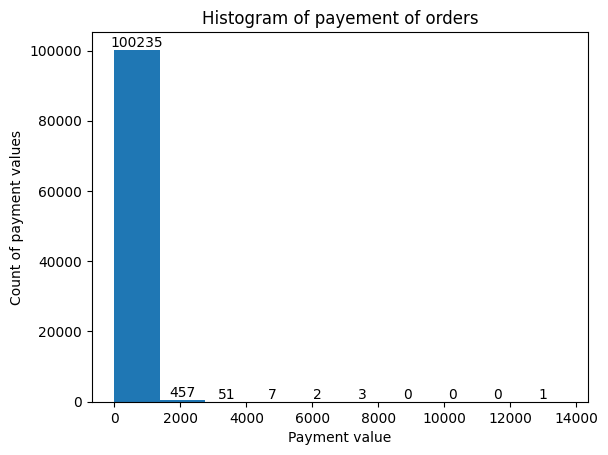

In [25]:
_, _, bars = plt.hist(olist_dataset["payment_value"])
plt.bar_label(bars)
plt.xlabel("Payment value")
plt.ylabel("Count of payment values")
plt.title("Histogram of payement of orders")
plt.show()

Calculate R,F,M

In [26]:
Monetary = olist_dataset.groupby('customer_id')['payment_value'].sum()
Monetary = Monetary.reset_index()
Monetary

,customer_id,payment_value
0,00012a2ce6f8dcda20d059ce98491703,114.74
1,000161a058600d5901f007fab4c27140,67.41
2,0001fd6190edaaf884bcaf3d49edf079,195.42
3,0002414f95344307404f0ace7a26f1d5,179.35
4,000379cdec625522490c315e70c7a9fb,107.01
...,...,...
96472,fffcb937e9dd47a13f05ecb8290f4d3e,91.91
96473,fffecc9f79fd8c764f843e9951b11341,81.36
96474,fffeda5b6d849fbd39689bb92087f431,63.13
96475,ffff42319e9b2d713724ae527742af25,214.13


In [27]:
Frequency = olist_dataset.groupby('customer_id')['order_id'].nunique()
Frequency = Frequency.reset_index()
Frequency

,customer_id,order_id
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1
...,...,...
96472,fffcb937e9dd47a13f05ecb8290f4d3e,1
96473,fffecc9f79fd8c764f843e9951b11341,1
96474,fffeda5b6d849fbd39689bb92087f431,1
96475,ffff42319e9b2d713724ae527742af25,1


In [28]:
latest_time = max(olist_dataset["order_purchase_timestamp"])
olist_dataset["day_diff"] = latest_time - olist_dataset["order_purchase_timestamp"]
olist_dataset["day_diff"] = olist_dataset["day_diff"].dt.days

Recency = olist_dataset.groupby("customer_id")['day_diff'].min()
Recency = Recency.reset_index()
Recency

,customer_id,day_diff
0,00012a2ce6f8dcda20d059ce98491703,287
1,000161a058600d5901f007fab4c27140,409
2,0001fd6190edaaf884bcaf3d49edf079,547
3,0002414f95344307404f0ace7a26f1d5,378
4,000379cdec625522490c315e70c7a9fb,149
...,...,...
96472,fffcb937e9dd47a13f05ecb8290f4d3e,165
96473,fffecc9f79fd8c764f843e9951b11341,152
96474,fffeda5b6d849fbd39689bb92087f431,99
96475,ffff42319e9b2d713724ae527742af25,76


In [29]:
RFM_olist = Monetary.merge(Frequency, left_on = "customer_id", right_on = "customer_id")
RFM_olist = RFM_olist.merge(Recency, left_on = "customer_id", right_on = "customer_id")

RFM_olist.rename({"payment_value": "Monetary","order_id": "Frequency", "day_diff":"Recency"}, axis = 1, inplace = True)
RFM_olist

,customer_id,Monetary,Frequency,Recency
0,00012a2ce6f8dcda20d059ce98491703,114.74,1,287
1,000161a058600d5901f007fab4c27140,67.41,1,409
2,0001fd6190edaaf884bcaf3d49edf079,195.42,1,547
3,0002414f95344307404f0ace7a26f1d5,179.35,1,378
4,000379cdec625522490c315e70c7a9fb,107.01,1,149
...,...,...,...,...
96472,fffcb937e9dd47a13f05ecb8290f4d3e,91.91,1,165
96473,fffecc9f79fd8c764f843e9951b11341,81.36,1,152
96474,fffeda5b6d849fbd39689bb92087f431,63.13,1,99
96475,ffff42319e9b2d713724ae527742af25,214.13,1,76


In [30]:
RFM_olist = RFM_olist[['Monetary', 'Frequency', 'Recency']]

RFM_olist = RFM_olist.sample(frac = 0.5)

# Instantiate
scaler = StandardScaler()
# fit_transform
rfm_olist_scaled = scaler.fit_transform(RFM_olist)
rfm_olist_scaled.shape

(48238, 3)

In [31]:
model_dict = {"DBSCAN": DBSCAN, "KMeans":KMeans, "Birch": Birch, "AgglomerativeClustering":AgglomerativeClustering}

for model_name, model in model_dict.items():
    cluster_score = {}
    for k_trial in range(3,10):
        model_instance = None
        if model_name != "DBSCAN":
            if model_name == "KMeans":
                model_instance = model(n_clusters = k_trial, n_init = "auto")
            else:
                model_instance = model(n_clusters = k_trial)
        else:
            model_instance = model()
        
        score = silhouette_score(rfm_olist_scaled, model_instance.fit_predict(rfm_olist_scaled))
        cluster_score[k_trial] = score
    
    # find optimal num clusters
    sort_score = {k: v for k, v in sorted(cluster_score.items(), key=lambda item: item[1])}
    
    optimal_cluster = list(sort_score.keys())[-1]
    optimal_score = sort_score[optimal_cluster]
    
    print(f"{model_name}, optimal cluster: {optimal_cluster}, optimal_score: {optimal_score}")

DBSCAN, optimal cluster: 9, optimal_score: 0.46879764639557303


KeyboardInterrupt: 

In [ ]:
model = KMeans(n_clusters = k_trial, n_init = "auto")
silhouette_score(rfm_olist_scaled, model.fit_predict(rfm_olist_scaled))